In [2]:
from custom_tokenizers.jieba_tokenizer import JiebaLikeTokenizer
from datasets import load_dataset

from model_instancies import model1

import torch
from trainer import SimpleTrainer

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/cq/3ryty8mx6qz8cqtn1ghkrvmm0000gn/T/jieba.cache
Loading model cost 0.254 seconds.
Prefix dict has been built successfully.


In [3]:
# Load and prepare dataset
dataset = load_dataset("parquet", data_files="../data/training_data/training_corpus.parquet")["train"]
dataset = dataset.shuffle(seed=42)
# dataset = dataset.select(range(10000))
dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_data = dataset['train']
val_data = dataset['test']

In [4]:
print(train_data)
print(val_data)

Dataset({
    features: ['input', 'label'],
    num_rows: 2999171
})
Dataset({
    features: ['input', 'label'],
    num_rows: 749793
})


In [5]:
print(train_data[0])

{'input': ['彪形大汉', '大惊失色', '，', '知道', '9', '4', '5', '4'], 'label': '自己'}


In [6]:
tokenizer = JiebaLikeTokenizer()

def preprocess(example):
    return {
        "input_ids": tokenizer.convert_tokens_to_ids(example["input"]),
        "labels": tokenizer.convert_tokens_to_ids([example["label"]], padding=False)[0],
    }

def add_attention_mask(example, tokenizer=tokenizer):
    return {
        "attention_mask": [0 if input_id==tokenizer.pad_token_id else 1 for input_id in example["input_ids"]],
    }

train_data = train_data.map(preprocess, num_proc=4, remove_columns=train_data.column_names)
val_data = val_data.map(preprocess, num_proc=4, remove_columns=val_data.column_names)
train_data = train_data.map(add_attention_mask, num_proc=4)
val_data = val_data.map(add_attention_mask, num_proc=4)

In [7]:
model = model1()
model.load_state_dict(torch.load("../models/model1_train1.pth"))

<All keys matched successfully>

In [8]:
batch_size = 32
num_epochs = 2
eval_interval = len(val_data) // batch_size

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

trainer = SimpleTrainer(
    model=model,
    train_dataset=train_data,
    val_dataset=val_data,
    batch_size=batch_size,
    num_epochs=num_epochs,
    device=device,
    eval_strategy="batch",
    eval_interval=eval_interval,
)

In [32]:
trainer.set_num_epochs(3)

In [33]:
trainer.train()

[Step 23431] Training - loss: 41642.5249, accuracy: 0.6250
[Step 23431] Validation - loss: 40745.1769, accuracy: 0.7045
[Step 46862] Training - loss: 44074.5925, accuracy: 0.6875
[Step 46862] Validation - loss: 40444.8337, accuracy: 0.7059
New best model saved
[Step 70293] Training - loss: 44803.4128, accuracy: 0.6875
[Step 70293] Validation - loss: 40081.0356, accuracy: 0.7078
New best model saved
[Step 93724] Training - loss: 45020.2430, accuracy: 0.6562
[Step 93724] Validation - loss: 40045.7160, accuracy: 0.7080
New best model saved


Epoch 17:   0%|          | 0/93725 [00:00<?, ?it/s]

[Step 23431] Training - loss: 40910.4965, accuracy: 0.5625
[Step 23431] Validation - loss: 40023.4281, accuracy: 0.7093
New best model saved
[Step 46862] Training - loss: 43270.6552, accuracy: 0.8438
[Step 46862] Validation - loss: 39923.9707, accuracy: 0.7087
New best model saved
[Step 70293] Training - loss: 44175.3523, accuracy: 0.5312
[Step 70293] Validation - loss: 39540.6183, accuracy: 0.7113
New best model saved
[Step 93724] Training - loss: 44137.1327, accuracy: 0.6250
[Step 93724] Validation - loss: 39275.9852, accuracy: 0.7122
New best model saved


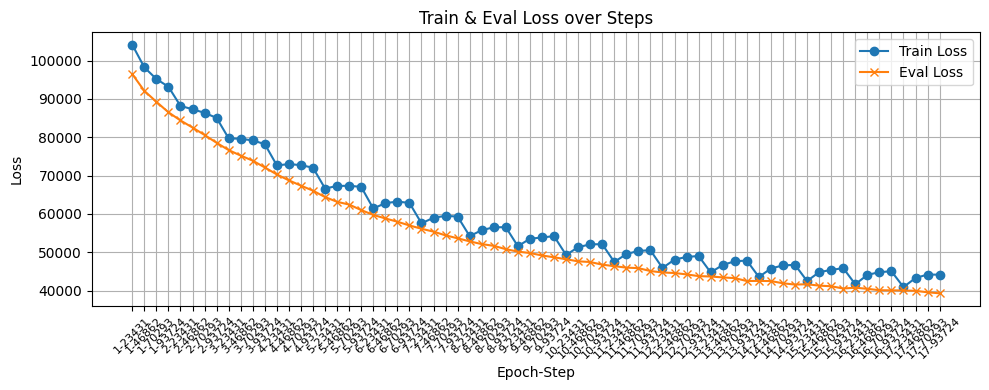

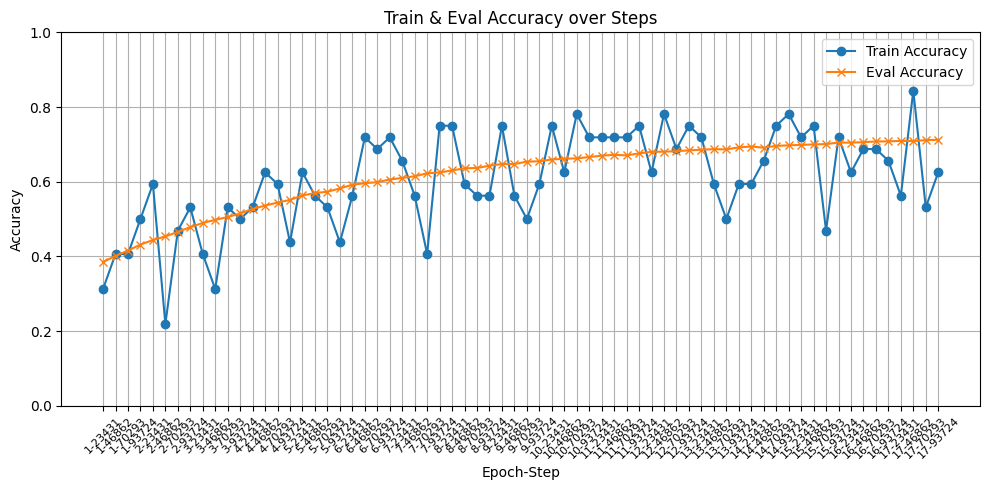

In [37]:
trainer.plot_training_log()

In [39]:
trainer.save_best_model("../models/model1_train2.pth")

Best model saved to ../models/model1_train2.pth
